In [1]:
#if alreasy installed, don't need to run following codes
#!conda update conda
#!conda config --add channels conda-forge
#!conda install spacy -y
#!python -m spacy download en

#!conda install scikit-learn -y
#!conda install beautifulsoup4 -y
#!conda install elasticsearch -y
#!pip install pyLDAvis

#for error ModuleNotFoundError: No module named 'cycler' when import matplotlib
#remember restart this notebook or using importlib.reload
#!conda remove matplotlib -y
#!conda remove cycler -y
#!pip uninstall cycler -y
#!pip uninstall matplotlib -y
#!pip install cycler
#!pip install matplotlib

In [9]:
from sklearn.model_selection import train_test_split
import time

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
  
from Models import DataLoadModel
from Utils import utilTools,utilDataPreprocess,utilLDA
import importlib
importlib.reload(DataLoadModel)
importlib.reload(utilTools)
importlib.reload(utilLDA)
importlib.reload(utilDataPreprocess)

IDFILE="./idlist.pkl"
DATAFILE="./preprocessed_data.pkl"
VECTORIZERFILE = "./vectorizer.pkl"

In [10]:
def savePreprocessedData(idlist, data, vectorizer):
    if idlist is None or data is None or vectorizer is None:
         raise ValueError('you must input three valid objects')
    try:
        utilTools.pickleDump(IDFILE, idlist)
        utilTools.pickleDump(DATAFILE, data)
        utilTools.pickleDump(VECTORIZERFILE, vectorizer)
    except Exception as e:
        print(e)
        print("save failed, idfile={}, dataFile={}, vectorizerFile={}".format(IDFILE, DATAFILE, VECTORIZERFILE))
        raise e

In [11]:
def loadPreprocessedData():
    try:
        idlist = utilTools.pickleLoad(IDFILE)
        data = utilTools.pickleLoad(DATAFILE)
        vetorizer = utilTools.pickleLoad(VECTORIZERFILE)
    except Exception as e:
        print(e)
        print("save failed, idfile={}, dataFile={}, vectorizerFile={}".format(IDFILE, DATAFILE, VECTORIZERFILE))
        raise e
        
    return idlist, data, vectorizer   

Wall time: 0 ns
load 100 preprocessed records in 0.0020058155059814453 Seconds
Topic #0:
day application linux language source information asp.net thing way page solution sure point method topic design connection line test project
Topic #1:
application able program time command good app library web datum error example information update process problem possible user idea way
Topic #2:
project table class site database datum asp.net large problem way code web application good experience thing service structure stuff connection
Topic #3:
project approach result update site new problem user file kind current code point message structure work application table tool time
Topic #4:
version time test way python function return string method different main option project day case example language server solution program
Topic #5:
file line process user machine sure way time script idea easy connection possible command approach issue current case service window
Topic #6:
server sql record new s

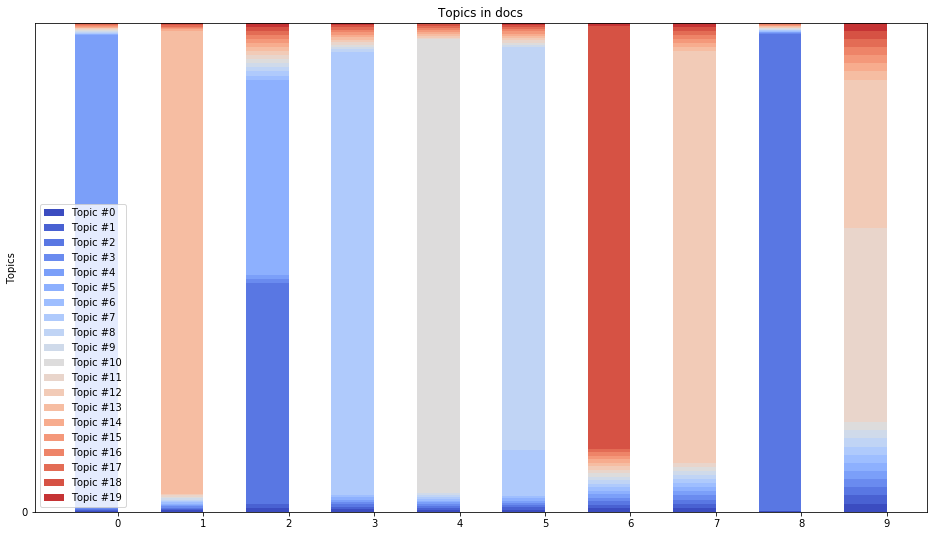

(10, 20)
19
[0.00172414 0.00172414 0.00172414 0.00172414 0.96724138 0.00172414
 0.00172414 0.00172414 0.00172414 0.00172414 0.00172414 0.00172414
 0.00172414 0.00172414 0.00172414 0.00172414 0.00172414 0.00172414
 0.00172414 0.00172414]


In [ ]:
%time
if __name__ == "__main__":
    
    try:
        start_time = time.time()
        idlist, X_train_preprocess, vectorizer = loadPreprocessedData()
        end_time = time.time()
        print("load {} preprocessed records in {} Seconds".format(len(idlist), end_time - start_time))
    except Exception as e:
        print("load preprocessed data failed, Will retrieve from dataset...")
        start_time = time.time()
        data = DataLoadModel.iterLoadStackoverflowFromES(100)
        end_time = time.time()
        print("Retrieved {} records in {} Seconds".format(len(data), end_time - start_time))
        #10001 records in 246.03912162780762 Seconds
    
        #print(data[1])
        X_train = [row[1] for row in data]
        idlist = [row[0] for row in data]
        #print(X_train[1])
        #Preprocess done in 420.02149057388306 Seconds, n_jobs=1, 10000 records
        #cpu_cores = multiprocessing.cpu_count()
        X_train_preprocess, vectorizer = utilDataPreprocess.preProcessData(X_train, 8, 1000)
        #save X_train_preprocess and vectorizer for multi later training
        try:
            savePreprocessedData(idlist, X_train_preprocess, vectorizer)
        except Exception as e:
            print("pickleDump Failed")
            pass 
    
    start_time = time.time()
    lda = utilLDA.trainLDA(X_train_preprocess, n_topics=20)
    feature_names = vectorizer.get_feature_names()
    utilLDA.print_top_words(lda, feature_names, 20)
    end_time = time.time()
    print("Trained LDA in {} Seconds".format(end_time - start_time))
    
    #get document_topic_distribution
    doc_topic_distr = lda.transform(X_train_preprocess[:10])
    utilLDA.visDocTopicDist(doc_topic_distr)
    print(doc_topic_distr.shape)
    print(idlist[0])
    print(doc_topic_distr[0])
    
    #utilLDA.visLDA(lda, X_train_preprocess, vectorizer, utilTools.getIP(), 8889)
    utilLDA.visLDA(lda, X_train_preprocess, vectorizer, "127.0.0.1",8889)